## Basic Agent

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load model and test data
model = tf.keras.models.load_model("1day_model.keras")
test_df = pd.read_pickle("test_df.pkl")

WINDOW = 30
FEATURES = ["Open", "High", "Low", "Close", "Volume"]

## Create Sequences for One Stock

In [ ]:
def make_sequences_for_stock(df, stock, window=WINDOW):
    """
    Prepares LSTM input sequences for a single stock.

    Parameters:
    df     : Full dataframe
    stock  : Stock ticker symbol
    window : Number of past timesteps used for prediction

    Returns:
    X        : 3D numpy array (samples, window, features)
    closes   : Closing prices aligned with predictions
    dates    : Dates aligned with predictions
    """
    
    # Filter data for selected stock and sort chronologically
    s = df[df["Stock"] == stock].copy().sort_values("Date")
    
    # Extract feature matrix and close prices
    data = s[FEATURES].values
    closes = s["Close"].values
    dates = s["Date"].values
    
    X = []
    close_targets = []
    date_targets = []
    
    # Create rolling window sequences
    for i in range(window, len(s)):
        # Past 'window' days used to predict day i
        X.append(data[i-window:i])
        
        # Store actual closing price at prediction time
        close_targets.append(closes[i])
        date_targets.append(dates[i])
    
    return np.array(X), np.array(close_targets), np.array(date_targets)

## Simple Rule-Based Trading Agent

In [ ]:
def run_agent(stock, initial_cash=10000):
    """
    Simple trading agent based on predicted return sign.

    Strategy:
    - If predicted return > 0 → invest all cash into stock
    - If predicted return < 0 → sell all shares
    - Otherwise hold position

    Parameters:
    stock        : Stock ticker
    initial_cash : Starting capital

    Returns:
    Dictionary containing portfolio history and final results.
    """
    
    # Prepare model input sequences
    X, closes, dates = make_sequences_for_stock(test_df, stock)
    
    if len(X) == 0:
        return None
    
    # Predict next-day returns
    predictions = model.predict(X, verbose=0).flatten()
    
    # Initialize portfolio
    cash = initial_cash
    shares = 0
    portfolio_values = []
    
    # Iterate over each prediction day
    for i in range(len(predictions)):
        pred = predictions[i]   # Model predicted return
        price = closes[i]       # Current closing price
        
        # If model predicts positive return → buy (if holding cash)
        if pred > 0 and cash > 0:
            shares = cash / price   # Buy as many shares as possible
            cash = 0
        
        # If model predicts negative return → sell (if holding shares)
        elif pred < 0 and shares > 0:
            cash = shares * price   # Sell all shares
            shares = 0
        
        # Compute total portfolio value at this time step
        portfolio_value = cash + shares * price
        portfolio_values.append(portfolio_value)
    
    return {
        "dates": dates,
        "portfolio_values": np.array(portfolio_values),
        "final_value": portfolio_values[-1],
        "initial_cash": initial_cash
    }

## Buy-and-Hold Baseline

In [ ]:
def buy_and_hold(stock, initial_cash=10000):
    """
    Baseline strategy:
    - Invest all capital on first day
    - Hold until the end
    - No trading

    Used for comparison with the agent.
    """
    
    s = test_df[test_df["Stock"] == stock].sort_values("Date")
    
    prices = s["Close"].values
    dates = s["Date"].values
    
    # Buy once at start
    shares = initial_cash / prices[0]
    
    # Portfolio value evolves with price
    portfolio_values = shares * prices
    
    return {
        "dates": dates,
        "portfolio_values": portfolio_values,
        "final_value": portfolio_values[-1],
        "initial_cash": initial_cash
    }

## Run Agent + Baseline

In [9]:
# Select first stock in test set
stock_name = test_df["Stock"].unique()[0]

# Run strategies
agent_result = run_agent(stock_name)
baseline_result = buy_and_hold(stock_name)

# Compute Return on Investment (ROI)
agent_roi = (
    agent_result["final_value"] - agent_result["initial_cash"]
) / agent_result["initial_cash"]

baseline_roi = (
    baseline_result["final_value"] - baseline_result["initial_cash"]
) / baseline_result["initial_cash"]

print("Agent Final Value:", agent_result["final_value"])
print("Agent ROI:", agent_roi)

print("Buy & Hold Final Value:", baseline_result["final_value"])
print("Buy & Hold ROI:", baseline_roi)

Agent Final Value: 10000.0
Agent ROI: 0.0
Buy & Hold Final Value: 7793.590662453539
Buy & Hold ROI: -0.22064093375464608


## Plot Portfolio Value Comparison

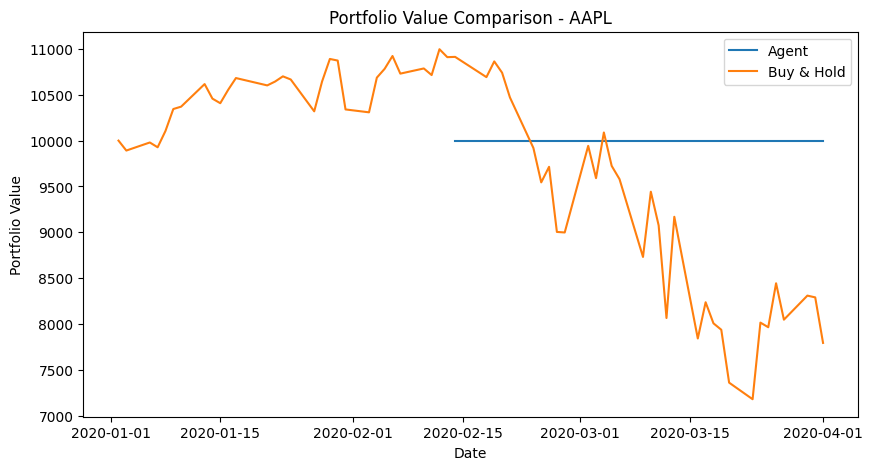

In [10]:
plt.figure(figsize=(10,5))

plt.plot(agent_result["dates"], agent_result["portfolio_values"], label="Agent")
plt.plot(baseline_result["dates"], baseline_result["portfolio_values"], label="Buy & Hold")

plt.title(f"Portfolio Value Comparison - {stock_name}")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()